# **Reto 6: Clasificación de géneros musicales a partir de redes neuronales con backpropagation**

In [1]:
!wget http://millionsongdataset.com/sites/default/files/AdditionalFiles/msd_genre_dataset.zip
!unzip msd_genre_dataset.zip
!cat msd_genre_dataset.txt | grep -E 'jazz and blues|soul and reggae' > filter_data.csv

--2019-09-24 23:28:18--  http://millionsongdataset.com/sites/default/files/AdditionalFiles/msd_genre_dataset.zip
Resolving millionsongdataset.com (millionsongdataset.com)... 173.231.209.32
Connecting to millionsongdataset.com (millionsongdataset.com)|173.231.209.32|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12656044 (12M) [application/zip]
Saving to: ‘msd_genre_dataset.zip’

msd_genre_dataset.z 100%[===================>]  12.07M  37.5MB/s    in 0.3s    

2019-09-24 23:28:19 (37.5 MB/s) - ‘msd_genre_dataset.zip’ saved [12656044/12656044]

Archive:  msd_genre_dataset.zip
  inflating: msd_genre_dataset.txt   


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import io
import numpy as np

nombres = ['y','ID','Author','Name','x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12','x13','x14','x15','x16','x17','x18','x19','x20','x21','x22','x23','x24','x25','x26','x27','x28','x29','x30']
datos = pd.read_csv('filter_data.csv', names = nombres)
datos = datos.reindex(np.random.permutation(datos.index))

data_array = datos.values

#Se ignora el artista, la ID y el nombre de la canción
relevant_data_0 = np.array([np.delete(x, [1,2,3]) for x in data_array])

#Selección de los géneros de interés y conversión a notación binaria (jazz and blues=0, soul and reggae=1)
relevant_data_1 = relevant_data_0
for x in relevant_data_0:
  if x[0] == 'jazz and blues':
    x[0] = 0
  elif x[0] == 'soul and reggae':
    x[0] = 1

from sklearn import preprocessing
relevant_data_1 = relevant_data_1.astype(np.float)

#Separación de datos de entrenamiento, validación y de prueba
trainX = preprocessing.normalize(relevant_data_1[2000:,1:])
trainY = relevant_data_1[2000:,0]

validationX = preprocessing.normalize(relevant_data_1[:1000,1:])
validationY = relevant_data_1[:1000,0]

testX = preprocessing.normalize(relevant_data_1[1000:2000,1:])
testY = relevant_data_1[1000:2000,0]

**Entrenamiento con 1 capa escondida**

In [0]:
def initialize_network(size_hidden_layer):
  size_input = len(trainX[0])
  size_output = 1 #Para este caso, se utiliza una capa de salida definida por 1 neurona
  network = []
  hidden_layer = [ {'weights':np.random.rand(size_input+1)} for i in range(size_hidden_layer) ] #Creación de neuronas en la capa oculta con pesos aleatorios
  network.append(hidden_layer)
  output_layer = [ {'weights':np.random.rand(size_hidden_layer+1)} for i in range(size_output) ] #Creación de neuronas en la última capa de salida
  network.append(output_layer)
  return network

def g(w,x): #Obtención de coeficiente a_j (en una neurona dada)
  y = w[-1] #Intercepto con el eje y, o peso con índice w_0
  for i in range(len(w)-1):
    y += w[i]*x[i]
  return y

def f_s(a): #Función de activación sigmoide
  y = 1/( 1 + np.exp(-a) )
  return y

def forward_prop(network, x):
  z = x #La entrada a la primera capa corresponde a los datos
  for layer in network:
    z_out = [] #Salida de la capa actual
    for neuron in layer:
      a = g(neuron['weights'],z)
      neuron['z'] = f_s(a) #En este caso, se utiliza una función de activación sigmoide
      z_out.append(neuron['z'])
    z = z_out #Las entradas a la siguiente capa corresponden a las salidas de la anterior
  return z_out

def f_s_prime(z):
  return z*(1-z)

def back_prop(network, y):
  #Se realiza un recorrido a partir de la última capa hasta la inicial
  for i in reversed(range(len(network))):
    current_layer = network[i]
    #Creación de un arreglo para guardar el error en cada capa
    error = []
    #Se obtiene el error propagado
    if i!=len(network)-1:
      next_layer = network[i+1]
      for j in range(len(current_layer)):
        e = 0
        #Obtención de error en cada neurona y suma ponderada
        for neuron in next_layer:
          e += neuron['weights'][j] * neuron['delta']
        error.append(e)
    #Obtención de error en la salida
    else:
      neuron = current_layer[0]
      error.append(y - neuron['z'])
    for j in range(len(current_layer)):
      neuron = current_layer[j]
      neuron['delta'] = error[j] * f_s_prime(neuron['z'])

def update_w(network, x, y, rate):
  for i in range(len(network)):
    current_layer = network[i]
    if i != 0:
      previous_layer = network[i-1]
      z = [neuron['z'] for neuron in previous_layer]
    else:
      z = x
    for neuron in current_layer:
      for j in range(len(z)):
        neuron['weights'][j] += rate*neuron['delta']*z[j]
      neuron['weights'][-1] += rate*neuron['delta']

from sklearn.metrics import accuracy_score
iteraciones = []
def train(network, x, y, rate, num_iterations):
  precisiones_entrenamiento = []
  for n in range(num_iterations):
    outputs = []
    #print("->Iteración",n)
    for j in range(len(x)):
      #Actualización con datos de entrenamiento
      z_out = forward_prop(network, x[j])
      if z_out[0]>0.5:
        z = 1
      else:
        z = 0
      outputs.append(z)
      back_prop(network, y[j])
      update_w(network, x[j], y[j], rate)

    precisiones_entrenamiento.append(accuracy_score(y,outputs))
    #print("Precisión:", accuracy_score(y,outputs))
  return precisiones_entrenamiento

def network_output(network, x_in):
  y_out = []
  for j in range(len(x_in)):
    #Obtención de salidas para datos de entrada
    z_out = forward_prop(network, x_in[j])
    if z_out[0]>0.5:
      z = 1
    else:
      z = 0
    y_out.append(z)
  return y_out

Precisión en los datos de prueba de 76.4 %


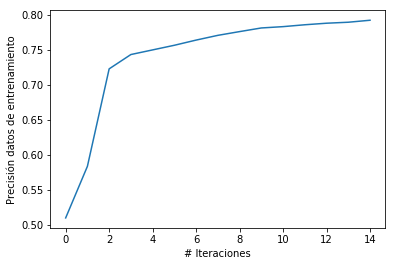

In [0]:
#Prueba de funcionamiento para 1 capa escondida 
num_its = 15
tasa = 1e-1
num_neuronas = 5

red = initialize_network(num_neuronas)
prec = train(red, trainX, trainY, tasa, num_its)

plt.plot(range(num_its), prec)
plt.xlabel('# Iteraciones')
plt.ylabel('Precisión datos de entrenamiento')

test_ac = accuracy_score(network_output(red, testX), testY)

print("Precisión en los datos de prueba de",test_ac*100,"%")

In [0]:
#Prueba de funcionamiento para 1 capa escondida ENTRE 2 y 20 NEURONAS

Nmin = 2
Nmax = 20
n_max_ac = 0
max_ac = 0
vector_val_ac = []
tasa = 1e-1
num_its = 15

for n in range(Nmin,Nmax):
  red_n = initialize_network(n)
  train(red_n, trainX, trainY, tasa, num_its)
  val_ac = accuracy_score(network_output(red_n, validationX), validationY)
  vector_val_ac.append(val_ac)
  if val_ac>max_ac:
    max_ac = val_ac
    n_max_ac = n
    red_max_ac = red_n

predY = network_output(red_max_ac, testX_normalized)
print("Precisión en datos de prueba", accuracy_score(network_output(red_max_ac, testX), testY))

plt.plot(range(Nmin,Nmax), vector_val_ac)
plt.ylim(0.5,1)
plt.xlabel('# Neuronas')
plt.ylabel('Precisión datos de validación')

Precisión en datos de prueba 0.782


**Entrenamiento con 2 capas escondidas**

In [0]:
def initialize_network_2_hidden_layers(size_hidden_layer):
  size_input = len(trainX[0])
  size_output = 1 #Para este caso, se utiliza una capa de salida definida por 1 neurona
  network = []
  hidden_layer_1 = [ {'weights':np.random.rand(size_input+1)} for i in range(size_hidden_layer) ] #Creación de neuronas en la capa oculta con pesos aleatorios
  network.append(hidden_layer_1)
  hidden_layer_2 = [ {'weights':np.random.rand(size_hidden_layer+1)} for i in range(size_hidden_layer) ] #Creación de neuronas en la capa oculta con pesos aleatorios
  network.append(hidden_layer_2)
  hidden_layer_3 = [ {'weights':np.random.rand(size_hidden_layer+1)} for i in range(size_hidden_layer) ] #Creación de neuronas en la capa oculta con pesos aleatorios
  network.append(hidden_layer_3)
  output_layer = [ {'weights':np.random.rand(size_hidden_layer+1)} for i in range(size_output) ] #Creación de neuronas en la última capa de salida
  network.append(output_layer)
  return network

def g(w,x): #Obtención de coeficiente a_j (en una neurona dada)
  y = w[-1] #Intercepto con el eje y, o peso con índice w_0
  for i in range(len(w)-1):
    y += w[i]*x[i]
  return y

def f_s(a): #Función de activación sigmoide
  y = 1/( 1 + np.exp(-a) )
  return y

def forward_prop(network, x):
  z = x #La entrada a la primera capa corresponde a los datos
  for layer in network:
    #print("->Capa")
    z_out = [] #Salida de la capa actual
    for neuron in layer:
      #print("-->Neurona")
      a = g(neuron['weights'],z)
      neuron['z'] = f_s(a) #En este caso, se utiliza una función de activación sigmoide
      z_out.append(neuron['z'])
    z = z_out #Las entradas a la siguiente capa corresponden a las salidas de la anterior
  return z_out

def f_s_prime(z):
  return z*(1-z)

def back_prop(network, y):
  #Se realiza un recorrido a partir de la última capa hasta la inicial
  for i in reversed(range(len(network))):
    current_layer = network[i]
    #Creación de un arreglo para guardar el error en cada capa
    error = []
    #Se obtiene el error propagado
    if i!=len(network)-1:
      next_layer = network[i+1]
      for j in range(len(current_layer)):
        e = 0
        #Obtención de error en cada neurona y suma ponderada
        for neuron in next_layer:
          e += neuron['weights'][j] * neuron['delta']
        error.append(e)
    #Obtención de error en la salida
    else:
      neuron = current_layer[0]
      error.append(y - neuron['z'])
    for j in range(len(current_layer)):
      neuron = current_layer[j]
      neuron['delta'] = error[j] * f_s_prime(neuron['z'])

def update_w(network, x, y, rate):
  for i in range(len(network)):
    current_layer = network[i]
    if i != 0:
      previous_layer = network[i-1]
      z = [neuron['z'] for neuron in previous_layer]
    else:
      z = x
    for neuron in current_layer:
      for j in range(len(z)):
        neuron['weights'][j] += rate*neuron['delta']*z[j]
      neuron['weights'][-1] += rate*neuron['delta']

from sklearn.metrics import accuracy_score
iteraciones = []
def train(network, x, y, rate, num_iterations):
  precisiones_entrenamiento = []
  for n in range(num_iterations):
    outputs = []
    for j in range(len(x)):
      #Actualización con datos de entrenamiento
      z_out = forward_prop(network, x[j])
      if z_out[0]>0.5:
        z = 1
      else:
        z = 0
      outputs.append(z)
      back_prop(network, y[j])
      update_w(network, x[j], y[j], rate)

    precisiones_entrenamiento.append(accuracy_score(y,outputs))
    #print("Iteración:",n,"Precisión:",accuracy_score(y,outputs))
  return precisiones_entrenamiento

def network_output(network, x_in):
  y_out = []
  for j in range(len(x_in)):
    #Obtención de salidas para datos de entrada
    z_out = forward_prop(network, x_in[j])
    if z_out[0]>0.5:
      z = 1
    else:
      z = 0
    y_out.append(z)
  return y_out

Iteración: 0 Precisión: 0.5022047244094489
Iteración: 1 Precisión: 0.5018897637795275
Iteración: 2 Precisión: 0.5018897637795275
Iteración: 3 Precisión: 0.5017322834645669
Iteración: 4 Precisión: 0.5017322834645669
Iteración: 5 Precisión: 0.5018897637795275
Iteración: 6 Precisión: 0.5018897637795275
Iteración: 7 Precisión: 0.5018897637795275
Iteración: 8 Precisión: 0.5018897637795275
Iteración: 9 Precisión: 0.5018897637795275
Iteración: 10 Precisión: 0.5018897637795275
Iteración: 11 Precisión: 0.5020472440944882
Iteración: 12 Precisión: 0.5022047244094489
Iteración: 13 Precisión: 0.5022047244094489
Iteración: 14 Precisión: 0.5022047244094489
Iteración: 15 Precisión: 0.5020472440944882
Iteración: 16 Precisión: 0.5023622047244094
Iteración: 17 Precisión: 0.5045669291338583
Iteración: 18 Precisión: 0.6530708661417323
Iteración: 19 Precisión: 0.7444094488188976
Iteración: 20 Precisión: 0.7559055118110236
Iteración: 21 Precisión: 0.7615748031496063
Iteración: 22 Precisión: 0.767086614173228

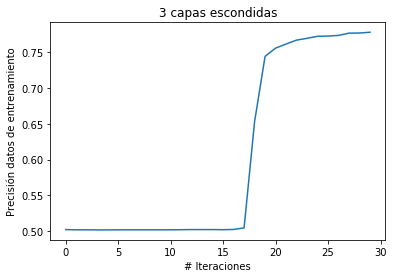

In [0]:
#Prueba de funcionamiento para 3 capas escondidas 
num_its = 30
tasa = 1
num_neuronas = 3

red = initialize_network_2_hidden_layers(num_neuronas)
prec = train(red, trainX, trainY, tasa, num_its)

plt.plot(range(num_its), prec)
plt.title('3 capas escondidas')
plt.xlabel('# Iteraciones')
plt.ylabel('Precisión datos de entrenamiento')

test_ac = accuracy_score(network_output(red, testX), testY)

print("Precisión en los datos de prueba de",test_ac*100,"%")

In [0]:
#Prueba de funcionamiento para 1 capa escondida ENTRE 2 y 20 NEURONAS

Nmin = 2
Nmax = 20
n_max_ac = 0
max_ac = 0
vector_val_ac = []
tasa = 1
num_its = 20

for n in range(Nmin,Nmax):
  print("->Neuronas",n)
  red_n = initialize_network_2_hidden_layers(n)
  train(red_n, trainX, trainY, tasa, num_its)
  val_ac = accuracy_score(network_output(red_n, validationX), validationY)
  vector_val_ac.append(val_ac)
  if val_ac>max_ac:
    max_ac = val_ac
    n_max_ac = n
    red_max_ac = red_n

predY = network_output(red_max_ac, testX)
print("Precisión en datos de prueba", accuracy_score(network_output(red_max_ac, testX), testY))

plt.plot(range(Nmin,Nmax), vector_val_ac)
plt.ylim(0.5,1)
plt.xlabel('# Neuronas')
plt.ylabel('Precisión datos de validación')

->Neuronas 2
->Neuronas 3
->Neuronas 4
->Neuronas 5
->Neuronas 6
->Neuronas 7
->Neuronas 8
->Neuronas 9
->Neuronas 10
->Neuronas 11
->Neuronas 12
->Neuronas 13
->Neuronas 14
->Neuronas 15
->Neuronas 16
->Neuronas 17
